# Feeder model

- Using open synth, generate a dataset of synthetic feeders with different proportions of EVs
  - Columns: `| feeder | number of customers | time | kWh profile | number of EVs` (or in long format)
  - Data should be using profiles from February only
  - For a feeder with N customers, sample N rows of data from Open Synth and sum them up 
  - Sample data uniformly across days of week
  - Record number of EVs 
  - Could also divide kWh usage by number of customers such that it's kWh profile per customer
- Fit a model predicting number of EVs for a given feeder profile
  - Model should take in features like overnight usage, daytime usage, peak daily kWh, difference between max and min demand
- Run inference on Weave data
  - Predict number of EVs for a given feeder
  - This will add a column to Weave data with number of feeders
- Plot results on a map (Paul)
  - Feeder geopoint and colour or size by number of EVs 

In [24]:
import pandas as pd
import numpy as np

In [25]:
df_os = pd.read_csv('data/OpenSynthFeb.csv', index_col=None)
df_os.shape

(250038, 15)

,profile,Unnamed: 0,month_of_year,day_of_week,has_heat_pump,has_home_battery,has_solar_pv,has_electric_hot_water,has_electric_radiator,is_mains_gas,property_type,energy_rating,urbanity,kwh,has_ev,has_lct,time_utc
0,0,117,2,3,True,True,True,False,False,True,Semi_Detached,A_B_C,Urban,2.001481,False,True,00:00:00
1,0,117,2,3,True,True,True,False,False,True,Semi_Detached,A_B_C,Urban,1.998775,False,True,00:30:00
2,0,117,2,3,True,True,True,False,False,True,Semi_Detached,A_B_C,Urban,1.946885,False,True,01:00:00
3,0,117,2,3,True,True,True,False,False,True,Semi_Detached,A_B_C,Urban,1.92315,False,True,01:30:00
4,0,117,2,3,True,True,True,False,False,True,Semi_Detached,A_B_C,Urban,1.894701,False,True,02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001819,250037,624292,2,6,False,False,False,False,False,True,Flat,A_B_C,Urban,0.093592,True,True,21:30:00
12001820,250037,624292,2,6,False,False,False,False,False,True,Flat,A_B_C,Urban,0.145362,True,True,22:00:00
12001821,250037,624292,2,6,False,False,False,False,False,True,Flat,A_B_C,Urban,0.178803,True,True,22:30:00
12001822,250037,624292,2,6,False,False,False,False,False,True,Flat,A_B_C,Urban,0.18992,True,True,23:00:00


In [26]:
def split_string(dframe_cell):
    return [float(x) for x in dframe_cell[1:-1].split(",")]
df_os["kwh"] = df_os["kwh"].apply(lambda q: split_string(q))
df_os = df_os.explode('kwh')

add time indicator column

In [27]:
times = pd.date_range('2024-01-01 00:00', '2024-01-01 23:30', freq='30min').time
df_os['time_utc'] = np.tile(times, int(df_os.shape[0]/48))
df_os = df_os.reset_index(names='profile')

Create sample feeders

- For 10,000 rows (e.g.) sample between 10 and 100 feeders at random
- Sum up their consumption for each time of day AND divide by number sampled

- Record number of EVs 

In [105]:
df_evs = df_os.filter(['profile', 'has_ev']).drop_duplicates()


EV_PROFILES_TO_KEEP = df_evs[df_evs.has_ev].sample(int(df_evs[~df_evs.has_ev].shape[0] * 0.05)).profile
NO_LCT_PROFILES = pd.Series(df_os[~df_os.has_lct].profile.unique())
PROFILES_TO_KEEP = pd.concat([df_evs[~df_evs.has_ev].profile, 
                              EV_PROFILES_TO_KEEP,
                             NO_LCT_PROFILES,
                             NO_LCT_PROFILES,
                             NO_LCT_PROFILES,
                             NO_LCT_PROFILES])


Creating training data" 

In [139]:
import matplotlib.pyplot as plt

N_ROWS = 1000

ls = []

df_os_to_sample = df_os[df_os.profile.isin(PROFILES_TO_KEEP)]
unique_profiles = pd.Series(df_os_to_sample.profile.unique())

for i in range(N_ROWS):
    N_TO_SAMPLE = np.random.randint(10, 100) # sample between 10 and 100 houses
    sample = unique_profiles.sample(N_TO_SAMPLE)
    df_feeder = df_os_to_sample[df_os_to_sample.profile.isin(sample)]
    N_EVS = sum(df_feeder.groupby('profile').has_ev.sum() > 0)
    
    df_feeder = df_feeder.groupby('time_utc').kwh.sum().to_frame()
    df_feeder['num_evs'] = N_EVS
    df_feeder['num_devices'] = N_TO_SAMPLE
    df_feeder['feeder_id'] = i
    
    ls.append(df_feeder)

# df_feeder.groupby('time_utc').kwh.sum().plot()


In [140]:
df_train = pd.concat(ls)
df_train['kwh_per_device'] = df_train['kwh'] / df_train['num_devices']

# this is the target
df_train['evs_per_device'] = df_train['num_evs'] / df_train['num_devices'] 

In [158]:
# add a night time column
night_times = pd.date_range('2024-01-01 23:00', '2024-01-02 06:00', freq='30min').time
df_train['nighttime'] = df_train.index.isin(night_times)

nighttime_usage = df_train[df_train.nighttime].groupby('feeder_id').kwh_per_device.sum()
daytime_usage = df_train[~df_train.nighttime].groupby('feeder_id').kwh_per_device.sum()
max_usage = df_train.groupby('feeder_id').kwh_per_device.max()
min_usage = df_train.groupby('feeder_id').kwh_per_device.min()
range_usage = max_usage - min_usage
num_evs = df_train.groupby('feeder_id').num_evs.max()

df_fit = pd.DataFrame([nighttime_usage, daytime_usage, max_usage, min_usage, range_usage, num_evs]).T
df_fit.columns = ['nighttime_usage', 'daytime_usage', 'max_usage', 'min_usage', 'range_usage', 'num_evs']

In [397]:
df_fit

,nighttime_usage,daytime_usage,max_usage,min_usage,range_usage,num_evs
feeder_id,,,,,,
0,8.725079,10.901848,0.973590,0.211614,0.761976,4.0
1,7.261002,11.241713,0.862875,0.187247,0.675628,3.0
2,7.072855,11.606708,0.830790,0.144548,0.686242,1.0
3,9.629608,14.373244,1.048419,0.263122,0.785297,0.0
4,8.474435,12.231464,0.979082,0.161630,0.817452,0.0
...,...,...,...,...,...,...
995,9.916766,15.043918,0.969471,0.272064,0.697407,5.0
996,9.646555,12.088749,1.002573,0.229363,0.773210,2.0
997,6.950408,11.013192,0.770262,0.209665,0.560596,5.0


### Fit model

In [162]:
from sklearn.linear_model import LinearRegression

X = df_fit.iloc[:, :-1].values
y = df_fit.iloc[:, -1].values

mod = LinearRegression().fit(X, y)
mod

LinearRegression()

### Loading the Weave data

In [164]:
import geopandas

In [165]:
df_weave = geopandas.read_parquet(
    "s3://weave.energy/smart-meter.parquet")

In [166]:
df_weave['time_utc'] = df_weave.data_collection_log_timestamp.dt.time

In [167]:
df_weave['import_kwh_per_device'] = df_weave.total_consumption_active_import/df_weave.aggregated_device_count_active

In [168]:
df_weave = df_weave[df_weave.import_kwh_per_device < df_weave.import_kwh_per_device.quantile(0.99)]

In [237]:
dfgroup = df_weave.groupby(['dno_alias', 'secondary_substation_unique_id','lv_feeder_unique_id','time_utc']).import_kwh_per_device.median().reset_index()

<Axes: >

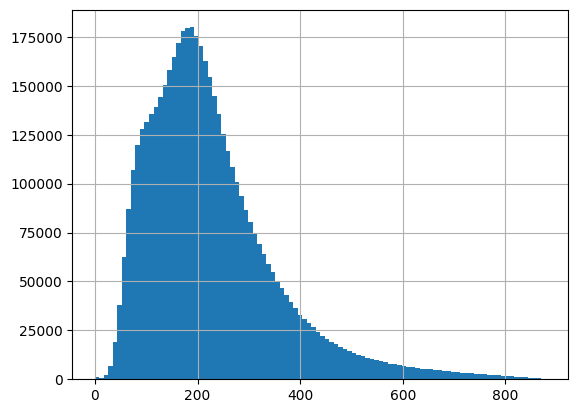

In [238]:
dfgroup.import_kwh_per_device.hist(bins=100)

Do some plots

Text(0, 0.5, 'Median Wh per device')

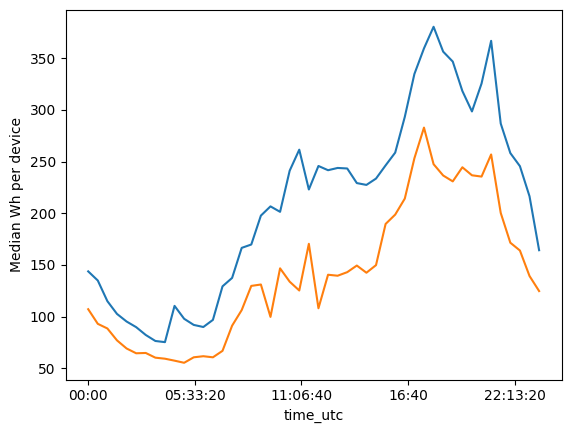

In [239]:
import matplotlib.pyplot as plt

m1 = dfgroup.secondary_substation_unique_id == '001'
m2 = dfgroup.lv_feeder_unique_id == '01'

dfgroup[m1 & m2].set_index('time_utc').import_kwh_per_device.plot()

m1 = dfgroup.secondary_substation_unique_id == '001'
m2 = dfgroup.lv_feeder_unique_id == '05'

dfgroup[m1 & m2].set_index('time_utc').import_kwh_per_device.plot()
plt.ylabel('Median Wh per device')

### Wrangle data for inference

In [248]:
df_inf = dfgroup.copy()
df_inf['feeder_id'] = df_inf['dno_alias'] + ' CONNECTS TO ' + df_inf['secondary_substation_unique_id'] + " CONNECTS TO " + df_inf['lv_feeder_unique_id']
df_inf['kwh_per_device'] = df_inf['import_kwh_per_device'] / 1000

In [250]:
# add a night time column
night_times = pd.date_range('2024-01-01 23:00', '2024-01-02 06:00', freq='30min').time
df_inf['nighttime'] = df_inf.time_utc.isin(night_times)

nighttime_usage = df_inf[df_inf.nighttime].groupby('feeder_id').kwh_per_device.sum()
daytime_usage = df_inf[~df_inf.nighttime].groupby('feeder_id').kwh_per_device.sum()

max_usage = df_inf.groupby('feeder_id').kwh_per_device.max()
min_usage = df_inf.groupby('feeder_id').kwh_per_device.min()
range_usage = max_usage - min_usage
# num_evs = df_train.groupby('feeder_id').num_evs.max()

df_go = pd.DataFrame([nighttime_usage, daytime_usage, max_usage, min_usage, range_usage]).T.dropna()
df_go.columns = ['nighttime_usage', 'daytime_usage', 'max_usage', 'min_usage', 'range_usage']

# run prediction
df_go['pred_num_evs'] = mod.predict(df_go.values)

In [398]:
df_go.head()

,nighttime_usage,daytime_usage,max_usage,min_usage,range_usage,pred_num_evs
feeder_id,,,,,,
NGED CONNECTS TO 110283-Newlyn Ave P CONNECTS TO 11-11,1.982105,7.956632,0.374579,0.099000,0.275579,1.361992
NGED CONNECTS TO 110283-Newlyn Ave P CONNECTS TO 21-21,2.584286,7.023143,0.370071,0.073929,0.296143,1.403258
NGED CONNECTS TO 110283-Newlyn Ave P CONNECTS TO 31-31,3.071125,9.685625,0.447750,0.140375,0.307375,1.677698
NGED CONNECTS TO 110362-Westbrook Road Id CONNECTS TO 11-11,1.190500,5.958200,0.263700,0.064800,0.198900,1.446149
NGED CONNECTS TO 110362-Westbrook Road Id CONNECTS TO 21-21,3.151125,6.200812,0.315000,0.121250,0.193750,2.789649


In [259]:
df_feeder_id = df_go.reset_index().feeder_id.str.split(' CONNECTS TO ', expand=True)
df_feeder_id.columns = ['dno_alias', 'secondary_substation_unique_id', 'lv_feeder_unique_id']
df_feeder_id['pred_num_evs'] = df_go['pred_num_evs'].values
df_feeder_id.set_index(['dno_alias', 'secondary_substation_unique_id', 'lv_feeder_unique_id', 'geometry'])
df_feeder_id

,dno_alias,secondary_substation_unique_id,lv_feeder_unique_id,pred_num_evs
0,NGED,110283-Newlyn Ave P,11-11,1.361992
1,NGED,110283-Newlyn Ave P,21-21,1.403258
2,NGED,110283-Newlyn Ave P,31-31,1.677698
3,NGED,110362-Westbrook Road Id,11-11,1.446149
4,NGED,110362-Westbrook Road Id,21-21,2.789649
...,...,...,...,...
103900,UKPN_EPN,EPN-S0000008U4666,2,2.069225
103901,UKPN_EPN,EPN-S0000008U4821,82,3.113530
103902,UKPN_EPN,EPN-S0000008U8615,0,2.284587
103903,UKPN_EPN,EPN-S0000008U8661,83,2.407320


In [268]:
df_weave_locs = df_weave.filter(['dno_alias', 'secondary_substation_unique_id', 'lv_feeder_unique_id', 'geometry']).drop_duplicates()

In [280]:
df_results = df_weave_locs.set_index(['dno_alias', 'secondary_substation_unique_id', 'lv_feeder_unique_id'])

In [307]:
df_results['predicted_evs'] = df_feeder_id.set_index(['dno_alias', 'secondary_substation_unique_id', 'lv_feeder_unique_id']).pred_num_evs.clip(0).round()

In [314]:
gdf = geopandas.GeoDataFrame(df_results.sample(100000))
gdf[gdf.predicted_evs >= 1]

geometry  \
dno_alias secondary_substation_unique_id lv_feeder_unique_id                                      
SSEN      020-LEE CRES CENTRL            03-LEE CRS NTH NES           POINT (-2.13073 57.19456)   
          245-FINTRY ROAD                04-FINTRAY RD NES TO PILLAR  POINT (-2.28658 57.21173)   
NGED      932784-STAVERTON LEYS RUGBY    5-5                          POINT (-1.26698 52.35444)   
SSEN      240-NEWSTEAD ROAD              05-25 Newstead Rd (SW)       POINT (-2.46244 50.60995)   
          175-ELLANBEICH SCHL            03-OVERHEAD SERVIC           POINT (-5.64486 56.29438)   
...                                                                                         ...   
          120-STATION ROAD               02                           POINT (-1.87037 50.90296)   
          080-OVERMEAD GREEN             03                           POINT (-1.20292 51.71979)   
          100-SUNBURY COURT ROAD         03                           POINT (-0.40111 51.41225)   
          020-GAITSIDE TERR              05-INCHBRAE DR ENS            POINT (-2.14364 57.1203)   
          030-STEPHENSON WAY             01                            POINT (-1.30479 50.9333)   

                                                                          pred  \
dno_alias secondary_substation_unique_id lv_feeder_unique_id                     
SSEN      020-LEE CRES CENTRL            03-LEE CRS NTH NES           1.038708   
          245-FINTRY ROAD                04-FINTRAY RD NES TO PILLAR  1.318270   
NGED      932784-STAVERTON LEYS RUGBY    5-5                          0.505721   
SSEN      240-NEWSTEAD ROAD              05-25 Newstead Rd (SW)       1.051540   
          175-ELLANBEICH SCHL            03-OVERHEAD SERVIC           2.055522   
...                                                                        ...   
          120-STATION ROAD               02                           1.708059   
          080-OVERMEAD GREEN             03                           1.302452   
          100-SUNBURY COURT ROAD         03                           1.072011   
          020-GAITSIDE TERR              05-INCHBRAE DR ENS           1.756505   
          030-STEPHENSON WAY             01                           1.663650   

                                                                      predicted_evs  
dno_alias secondary_substation_unique_id lv_feeder_unique_id                         
SSEN      020-LEE CRES CENTRL            03-LEE CRS NTH NES                     1.0  
          245-FINTRY ROAD                04-FINTRAY RD NES TO PILLAR            1.0  
NGED      932784-STAVERTON LEYS RUGBY    5-5                                    1.0  
SSEN      240-NEWSTEAD ROAD              05-25 Newstead Rd (SW)                 1.0  
          175-ELLANBEICH SCHL            03-OVERHEAD SERVIC                     2.0  
...                                                                             ...  
          120-STATION ROAD               02                                     2.0  
          080-OVERMEAD GREEN             03                                     1.0  
          100-SUNBURY COURT ROAD         03                                     1.0  
          020-GAITSIDE TERR              05-INCHBRAE DR ENS                     2.0  
          030-STEPHENSON WAY             01                                     2.0  

[93164 rows x 3 columns]

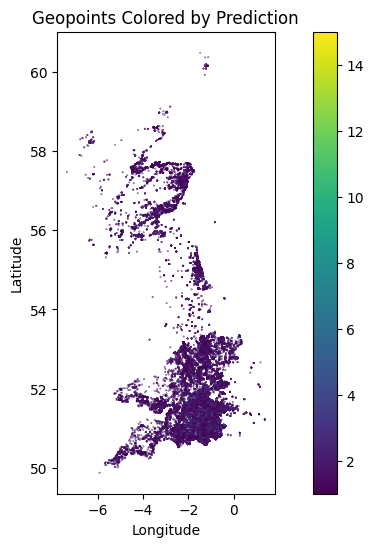

In [316]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf[gdf.predicted_evs >= 1].plot(
    column='predicted_evs',  # Column to color by
    cmap='viridis', # Colormap
    legend=True,    # Add a legend
    ax=ax,
    markersize=0.1  # Size of the points
)

# Customize plot
ax.set_title("Geopoints Colored by Prediction")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

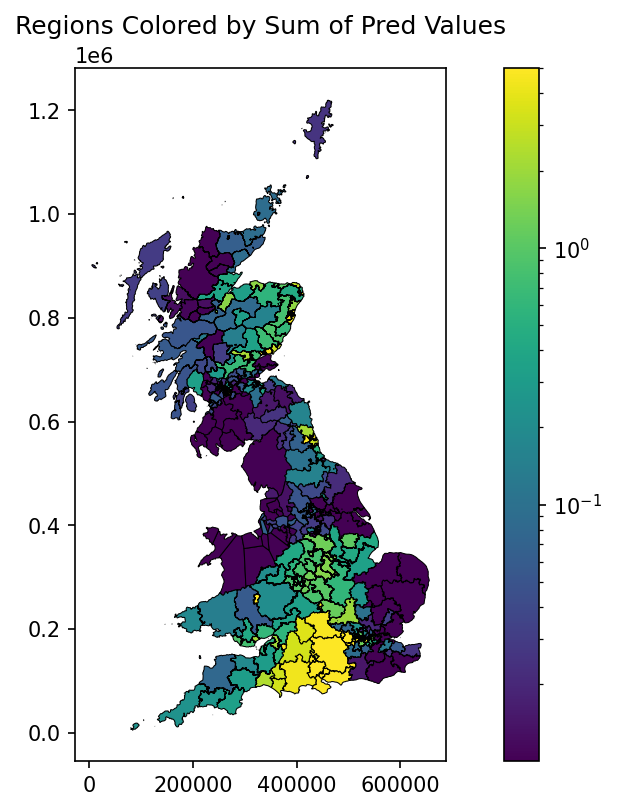

In [396]:

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the shapefile with geographic regions
gsp_regions = gpd.read_file("data/gsp_regions_20220314/GSP_regions_20220314.shp").set_index('GSPs')

points = gpd.GeoDataFrame(df_results, geometry=df_results.geometry)

# Ensure CRS match between points and regions
points = points.to_crs(gsp_regions.crs)

# Spatial join: associate points with regions
points_with_regions = gpd.sjoin(points, gsp_regions, how="inner", predicate="within")

# Aggregate the `pred` values by region
region_aggregated = points_with_regions.groupby(gsp_regions.index.name)['predicted_evs'].sum()

# Add the aggregated values back to the regions GeoDataFrame
gsp_regions['pred_sum'] = gsp_regions.index.map(region_aggregated).fillna(0)

# Calculate the area of each region in square kilometers
gsp_regions['area_km2'] = gsp_regions.geometry.to_crs({'proj': 'cea'}).area / 1e6  # Convert area to km²

# Normalize the pred_sum by the area
gsp_regions['pred_normalized'] = gsp_regions['pred_sum'] / gsp_regions['area_km2']

# Plot the regions, colored by the aggregated `pred` values
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)


gsp_regions['pred_normalized'] = gsp_regions.pred_normalized.clip(0.01, 5)
gsp_regions.plot(column='pred_normalized', 
             cmap='viridis', 
             legend=True, 
             edgecolor='black', 
             linewidth=0.5,
                norm=mcolors.LogNorm(vmin=gsp_regions['pred_normalized'].min() + 1e-6, 
                                      vmax=gsp_regions['pred_normalized'].max()),     
             ax=ax)

# Customize the plot
ax.set_title("Regions Colored by Sum of Pred Values")
plt.savefig('outputs/ev_map.png')


In [400]:
gsp_regions.to_csv('outputs/GSP_predictions.csv')

np.float64(24783.0)

In [351]:
points_with_regions = gpd.sjoin(gsp_regions, points, how="inner", predicate="contains")
points_with_regions

,GSPGroup,geometry,pred_sum,dno_alias,secondary_substation_unique_id,lv_feeder_unique_id,pred,predicted_evs
GSPs,,,,,,,,


In [363]:
gsp_regions.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [366]:
points.to_crs(gsp_regions.crs)

geometry  \
dno_alias secondary_substation_unique_id lv_feeder_unique_id                          
NGED      110283-Newlyn Ave P            11-11                 POINT (-2.64 51.484)   
                                         21-21                 POINT (-2.64 51.484)   
                                         31-31                 POINT (-2.64 51.484)   
          110362-Westbrook Road Id       11-11                POINT (-2.552 51.426)   
                                         21-21                POINT (-2.552 51.426)   
...                                                                             ...   
NPg       148550787-CRASTER SOUTH        59884-C-59884-C       POINT (-1.594 55.47)   
SSEN      080-ROTHERFIELD ROAD           04                   POINT (-0.904 51.525)   
NGED      181144-Plood Lane              10-10                POINT (-2.789 51.343)   
UKPN_EPN  EPN-R00000000B43H-000-089Z     81                   POINT (-0.558 52.189)   
NPg       148553345-GUISBOROUGH HOSPITAL 62871-C-62871-C      POINT (-1.053 54.539)   

                                                                  pred  \
dno_alias secondary_substation_unique_id lv_feeder_unique_id             
NGED      110283-Newlyn Ave P            11-11                1.361992   
                                         21-21                1.403258   
                                         31-31                1.677698   
          110362-Westbrook Road Id       11-11                1.446149   
                                         21-21                2.789649   
...                                                                ...   
NPg       148550787-CRASTER SOUTH        59884-C-59884-C     -0.883522   
SSEN      080-ROTHERFIELD ROAD           04                   3.178901   
NGED      181144-Plood Lane              10-10                1.295461   
UKPN_EPN  EPN-R00000000B43H-000-089Z     81                  -0.463898   
NPg       148553345-GUISBOROUGH HOSPITAL 62871-C-62871-C      2.303210   

                                                              predicted_evs  
dno_alias secondary_substation_unique_id lv_feeder_unique_id                 
NGED      110283-Newlyn Ave P            11-11                          1.0  
                                         21-21                          1.0  
                                         31-31                          2.0  
          110362-Westbrook Road Id       11-11                          1.0  
                                         21-21                          3.0  
...                                                                     ...  
NPg       148550787-CRASTER SOUTH        59884-C-59884-C                0.0  
SSEN      080-ROTHERFIELD ROAD           04                             3.0  
NGED      181144-Plood Lane              10-10                          1.0  
UKPN_EPN  EPN-R00000000B43H-000-089Z     81                             0.0  
NPg       148553345-GUISBOROUGH HOSPITAL 62871-C-62871-C                2.0  

[103925 rows x 3 columns]

In [364]:
gsp_regions

,GSPGroup,geometry
GSPs,,
BRED_1,_G,"POLYGON ((396643.822 382551.233, 396689.851 38..."
CARR_1,_G,"POLYGON ((368430.177 388922.626, 368596.252 39..."
HARK_1|HUTT_1|RRIG,_G,"POLYGON ((373761.066 465853.11, 373759.92 4658..."
HEYS_1|HEYS1|ORMO,_G,"POLYGON ((352226.925 470438.338, 354729.926 47..."
KEAR_1|KEAR_3,_G,"POLYGON ((383203.121 405526.73, 382471.732 403..."
...,...,...
ALVE1,_L,"MULTIPOLYGON (((272991 93144, 272890.5 93144, ..."
AXMI1,_L,"MULTIPOLYGON (((321814 101551, 321814 101651, ..."
EXET1,_L,"POLYGON ((272890.5 92343, 272790 92343, 272790..."
